In [303]:
import brian2 as br
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy
import scipy as sp

from scipy import optimize as op
import seaborn as sns

import dh_parameters as dp
import dh_model as dh

%matplotlib notebook
reload(dp);
reload(dh);

In [307]:
nts = ['pr_noci','e_nts','i_gal']
ats = ['pep2','AB_ltmr']
Ns = dp.get_Ns()
intrinsics_df = dp.intrinsics_table_w_units()
ng_output_dfs = dp.interneuronal_connectivity_tables()
ag_output_dfs = dp.afferent_connectivity_tables()
ndf = {}
adf ={}

for param,df in ng_output_dfs.items():
    ndf[param] = ng_output_dfs[param].loc[['pr_noci','e_nts','i_gal'],['pr_noci','e_nts','i_gal']]

for param,df in ag_output_dfs.items():
    adf[param] = ag_output_dfs[param].loc[['pep2'],['pr_noci','e_nts','i_gal']]    
    
for param,df in ndf.items():
    ndf[param].columns = ['pr_noci', 'e_nts', 'i_WDR']
    ndf[param].index = ['pr_noci', 'e_nts', 'i_WDR']
    
for param,df in adf.items():
    adf[param].columns = ['pr_noci', 'e_nts', 'i_WDR']
    
ndf['p'].loc['i_WDR'] = [0.5,0.5,0.5]
ndf['w_mu'].loc['i_WDR'] = [1.e-9,1.0e-9,0.5e-9]
ndf['w_sigma'].loc['i_WDR'] = [1e-10,1e-10,1e-10]
ndf['conductance_name'].loc['i_WDR']=['i','i','i']

ndf['p'].loc['e_nts'] = [0.5,0.25,0.25]
ndf['w_mu'].loc['e_nts'] = [0.25e-9,0.25e-9,0.5e-9]
ndf['w_sigma'].loc['e_nts'] = [1e-10,0.25e-9,0.5e-9]
ndf['conductance_name'].loc['e_nts']=['e','e','e']

adf['p'].loc['pep2'] = [0.5,0.,0.5]
adf['w_mu'].loc['pep2'] = [1.5e-9,1e-9,1e-9]
adf['w_sigma'].loc['pep2'] = [1e-9,1e-9,1e-9]
adf['conductance_name'].loc['pep2']=['e','e','e']

adf['p'].loc['AB_ltmr'] = [0,0.5,0.5]
adf['w_mu'].loc['AB_ltmr'] = [1e-9,1.5e-9,0.5e-9]
adf['w_sigma'].loc['AB_ltmr'] = [1e-9,1e-9,1e-9]
adf['conductance_name'].loc['AB_ltmr']=['e','e','e']


nts = ['pr_noci', 'e_nts', 'i_WDR']
Ns['pr_noci'] = 20
Ns['e_nts'] = 60
Ns['i_WDR'] = 20
Ns['pep2'] = 200
Ns['AB_ltmr'] = 200

intrinsics_df.loc['i_WDR'] = intrinsics_df.loc['i_gal']

for nt in nts:
    intrinsics_df.loc[nt,'tau_r'] = 0.2 
    intrinsics_df.loc[nt,'V_r'] = -70 
    intrinsics_df.loc[nt,'tau_u'] = 100
    intrinsics_df.loc[nt,'alpha'] = 1
    intrinsics_df.loc[nt,'b'] = 10
    
intrinsics_df.loc['i_WDR','b'] = 0
intrinsics_df.loc['i_WDR','alpha'] = 0.1
intrinsics_df.loc['i_WDR','g_l_mu'] = 4

In [308]:
reload(dh)

ds = dh.sim()
ds['dt'] = sim_dt = 0.1*br.ms
ds['nts'] = nts
ds['ats'] = ats
ds['adf'] = adf
ds['ndf'] = ndf
ds['intrinsics_df'] = intrinsics_df.loc[nts + ['units'],:]
ds['Ns'] = Ns

ds.initialize_sim_objects()
wdf,wmat = ds.get_weight_matrix()

<IPython.core.display.Javascript object>


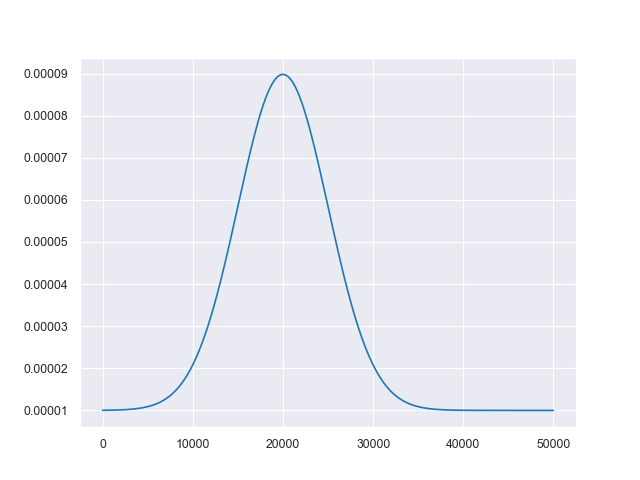

In [324]:

plt.figure()
plt.plot(psth_kernel)

In [374]:
#output = tensor: rates x psth x num_trials

block_length = 1
conditions = 2
num_repeats = 1
duration = 5000 * br.ms
num_trials = block_length * conditions * num_repeats
print('num_trials = '+ str(num_trials))
trial_durations = [duration] * num_trials
ds.initialize_inputs(trial_durations)

#let's make this simpler


# off_time_frac = 0.2
# psth_kernel,_ = dh.uniform_psth(duration*(1-off_time_frac), ds['dt'])

# psth_kernel = np.concatenate([np.zeros(int(duration*off_time_frac/ds['dt'])),psth_kernel])

rates_of_active_pep2 = np.array([0,5])
rates_of_active_AB_ltmr = np.array([5,0.3])


frac_active_pep2= np.ones(num_trials)
frac_active_AB_ltmr = np.ones(num_trials)

heat = ([True]*block_length +[False] * block_length)  * num_repeats


mech = ([False]*block_length +[True] * block_length)  * num_repeats


psth_kernel,_ = dh.gaussian_psth(duration, ds['dt'], mu = 2000 * br.ms, sigma = 300 * br.ms)
background,_ = dh.uniform_psth(duration, ds['dt'])
psth_kernel += background*0.01
at = 'pep2'
for trial,frac in enumerate(frac_active_pep2):
    _, active_binary = dh.make_active_inds_binary(frac, ds['ags'][at].N)
    rate_vec = np.ones((ds['ags'][at].N))* rates_of_active_pep2[trial] * active_binary
    spike_times,indices = dh.generate_population_spikes(psth_kernel,rate_vec,sim_dt)
    ds['inputs'][trial][at]['spike_times'] = spike_times
    ds['inputs'][trial][at]['indices'] = indices

psth_kernel,_ = dh.gaussian_psth(duration, ds['dt'], mu = 2000 * br.ms, sigma = 500 * br.ms)
background,_ = dh.uniform_psth(duration, ds['dt'])
psth_kernel += background*0.06
at = 'AB_ltmr'
for trial,frac in enumerate(frac_active_AB_ltmr):
    _, active_binary = dh.make_active_inds_binary(frac, ds['ags'][at].N)
    rate_vec = np.ones((ds['ags'][at].N))* rates_of_active_AB_ltmr[trial] * active_binary
    spike_times,indices = dh.generate_population_spikes(psth_kernel,rate_vec,sim_dt)
    ds['inputs'][trial][at]['spike_times'] = spike_times
    ds['inputs'][trial][at]['indices'] = indices
    
df = pd.DataFrame({'frac_active_pep2':frac_active_pep2,
                   'frac_active_AB_ltmr':frac_active_AB_ltmr,
                   'rates_of_active_pep2':rates_of_active_pep2,
                   'rates_of_active_AB_ltmr':rates_of_active_AB_ltmr})
df['heat'] = heat
df['mech'] = mech

ds.initialize_target_outputs()
ds.finalize_inputs()

# nt = 'i_WDR'
# silenced_i_WDR = np.concatenate([np.ones(block_length*2)*-50000]* num_repeats )
# for trial,current in enumerate(silenced_i_WDR):
#     ds['inputs'][trial][nt]['I_ex'] += current
    
# df['silenced_i_WDR'] = silenced_i_WDR
# df['silenced'] = df['silenced_i_WDR']<0

num_trials = 2


<IPython.core.display.Javascript object>


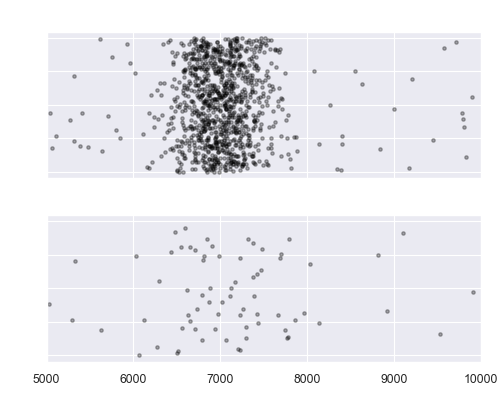

[]

In [422]:
# ds.plot_ag_psths();
f, ax = ds.plot_ag_rasters(fig_kwargs={'figsize':(5,4)},plot_kwargs={'alpha':0.3,'color':'k'});
ax[0].set_xlim((5000,10000))
ax[0].set_title('')
ax[0].set_yticklabels('')
ax[1].set_title('')
ax[1].set_yticklabels('')

In [423]:
f.savefig('/Users/nakaa1/Documents/Presentations/20190503_postdoc_meeting/nociafferent.png',dpi=300)

In [376]:
ds['network'].restore()

In [377]:
ds.run_sim()

In [378]:
observed_spikes = ds.get_trialwise_spikes()

In [379]:
for j,nt in enumerate(nts):
    this_rates = [observed_spikes[i][nt]['mean_count'] for i in range(len(observed_spikes))]
    df[nt+'_mean_rate'] = this_rates

spikes_df = dh.spikes_to_df(ds)

<IPython.core.display.Javascript object>


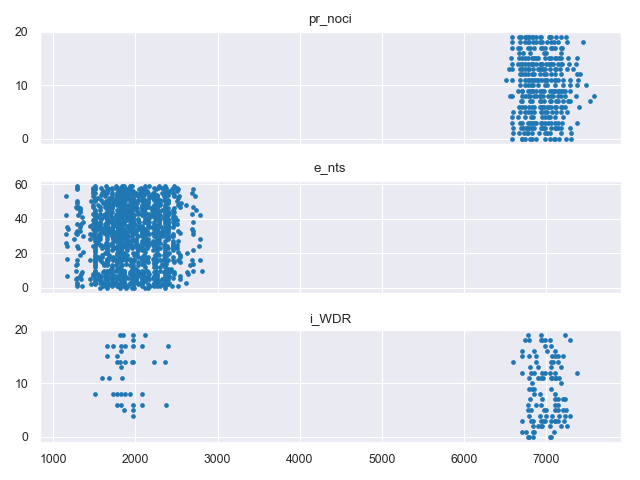

(<Figure size 640x480 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a3d82bef0>,
       dtype=object))

In [380]:
ds.plot_ng_rasters()

<IPython.core.display.Javascript object>


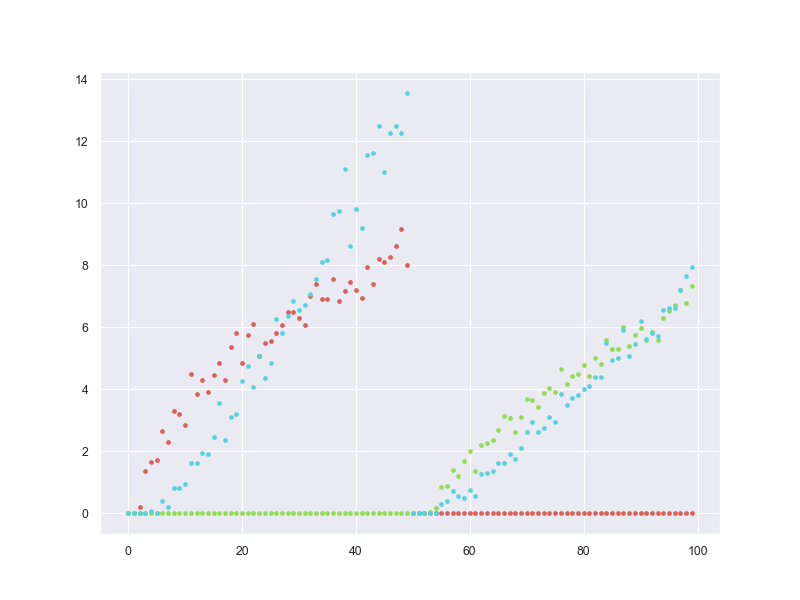

In [294]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (8,6), sharex = True)
y_bias = 0
for j,nt in enumerate(nts):
    this_rates = [observed_spikes[i][nt]['mean_count'] for i in range(len(observed_spikes))]
    ax.plot(this_rates,'.',color=cmap[j])

<IPython.core.display.Javascript object>


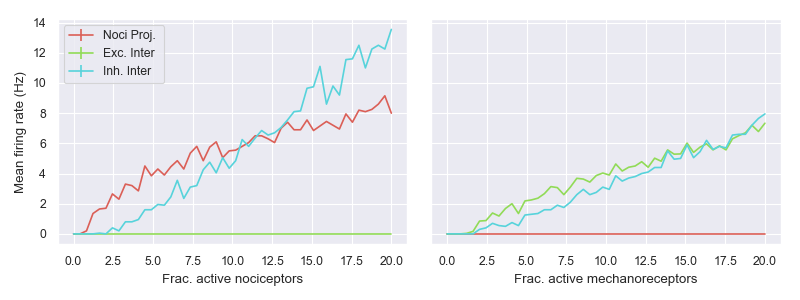

In [296]:
sns.set_style('darkgrid')
sns.set_context('paper')
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,2,figsize = (8,3), sharex = True,sharey = True)
ax = ax.flatten()


heat_ctrl = df['heat'] 
mech_ctrl = df['mech'] 

inds = [heat_ctrl,mech_ctrl]
ivs = ['rates_of_active_pep2','rates_of_active_AB_ltmr']

for i, (ind,iv) in enumerate(zip(inds,ivs)):
    this_df = df[ind]
    agg_df = this_df.groupby(iv).agg(['mean','std']).reset_index()
    ax[i].errorbar(agg_df[iv],agg_df['pr_noci_mean_rate']['mean'],
                   agg_df['pr_noci_mean_rate']['std'],color = cmap[0],
                   linestyle = '-',marker = 'None')
    ax[i].errorbar(agg_df[iv],agg_df['e_nts_mean_rate']['mean'],
                   agg_df['e_nts_mean_rate']['std'],color = cmap[1],
                   linestyle = '-',marker = 'None')
    ax[i].errorbar(agg_df[iv],agg_df['i_WDR_mean_rate']['mean'],
                   agg_df['i_WDR_mean_rate']['std'],color = cmap[2],
                   linestyle = '-',marker = 'None')
#     ax[i].set_xscale('log')
ax[0].legend(['Noci Proj. ','Exc. Inter','Inh. Inter'])
ax[0].set_xlabel('Frac. active nociceptors')
ax[1].set_xlabel('Frac. active mechanoreceptors')
ax[0].set_ylabel('Mean firing rate (Hz)')
plt.tight_layout()

# f.savefig('/Users/nakaa1/data/DH_model_outputs/simple_circuit/stronger_E_to_pr_IO.png',dpi = 300)

In [119]:
ds['spike_mons']['pr_noci']

<SpikeMonitor, recording from spikemonitor_3>

In [381]:
dh.make_all_sim_spikes_pretty(ds)

<IPython.core.display.Javascript object>


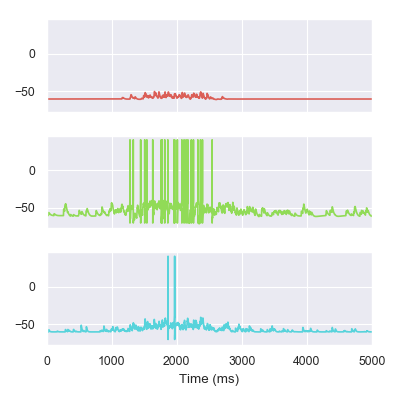

1


In [399]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(3,1,figsize = (4,4), sharex = True,sharey = True)
ax = ax.flatten()
y_bias = 0
# state_mon =ds['state_mons']['pr_noci']
z = np.random.choice(20)
for j, nt in enumerate(ds['state_mons']):
    state_mon =ds['state_mons'][nt]
    ax[j].plot(state_mon.t/br.ms, state_mon.v[5,:]/br.mV, color = cmap[j]);
#     ax[j].plot(state_mon.t/br.ms, state_mon.v[z,:], color = 'k');
#     y_bias += ngs[ct].N
    ax[j].set_xlim((0,5000))
    
y_bias+=1

print(z)
# ax[0].set_ylabel('mV')

# ax[0].set_title('Pain projection neuron',color = cmap[0])
# ax[1].set_title('Excitatory interneuron',color = cmap[1])
# ax[2].set_title('Inhibitory neuron',color = cmap[2])
# ax[1].set_ylabel('Membrane potential (mV)')
# ax[2].set_ylabel('mV')
ax[2].set_xlabel('Time (ms)')
# ax[1].set_ylabel('Membrane potential (mV)')
plt.tight_layout()


In [400]:
f.savefig('/Users/nakaa1/Documents/Presentations/20190503_postdoc_meeting/mech_vm_example2.png',dpi=300)

In [ ]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (8,6), sharex = True)
y_bias = 0
for j,(ct,spike_mon) in enumerate(sim_objects['spike_mons'].items()):
    ax.plot(spike_mon.t/br.ms, spike_mon.i + y_bias,'.', color = cmap[j],alpha = 0.1);
    y_bias += ngs[ct].N
    
ax.plot(ag_inputs_full_trial['pep2']['spike_times']/br.ms,
        ag_inputs_full_trial['pep2']['indices']+y_bias,'.',color='k',alpha = 0.1)
ax.plot(ag_inputs_full_trial['AB_ltmr']['spike_times']/br.ms,
        ag_inputs_full_trial['AB_ltmr']['indices']+y_bias,'.',color='y',alpha = 0.1)
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
# ax.set_xlim((0,net.t/br.ms))
# ax.set_xlim((0,1000))

<IPython.core.display.Javascript object>


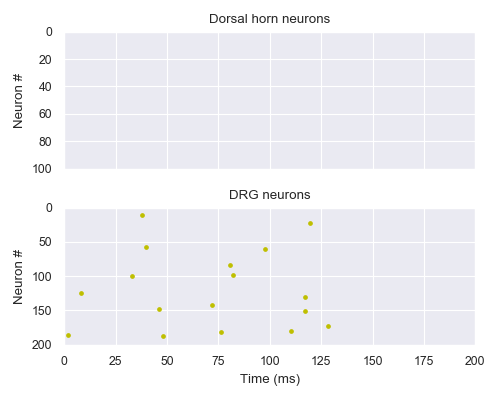

In [362]:
trial = 0

cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(2,1,figsize = (5,4), sharex = True)
ax = ax.flatten()

y_bias = 0
for j,nt in enumerate(['pr_noci','e_nts','i_WDR']):
    ind = (spikes_df['trial']==trial) & (spikes_df['type'] == nt)
    ax[0].plot(spikes_df.loc[ind,'trial_t']/br.ms,spikes_df.loc[ind,'i']+y_bias,'.', color = cmap[j],alpha = 0.7)
    y_bias += ds['ngs'][nt].N
    
ax[0].set_ylim((y_bias,0))
ax[0].set_ylabel('Neuron #')
ax[0].set_title('Dorsal horn neurons')
ax[0].set_xlim((0,200))


y_bias = 0 
nt = 'pep2'
ind = (spikes_df['trial']==trial) & (spikes_df['type'] == nt)
ax[1].plot(spikes_df.loc[ind,'trial_t']/br.ms,spikes_df.loc[ind,'i']+y_bias,'.', color = 'k')

y_bias = 0 
nt = 'AB_ltmr'
ind = (spikes_df['trial']==trial) & (spikes_df['type'] == nt)
ax[1].plot(spikes_df.loc[ind,'trial_t']/br.ms,spikes_df.loc[ind,'i']+y_bias,'.', color = 'y')
ax[1].set_ylabel('Neuron #')
ax[1].set_title('DRG neurons')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylim((200,0))
plt.tight_layout()
# f.savefig('/Users/nakaa1/data/DH_model_outputs/simple_circuit/heat_disinhibition_spiking.png',dpi = 300)

<IPython.core.display.Javascript object>


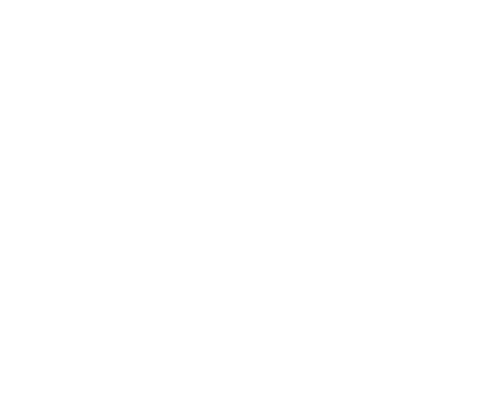

NameError: name 'sim_objects' is not defined

In [298]:
trial = 73

cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(2,1,figsize = (5,4), sharex = True)
ax = ax.flatten()

y_bias = 0
for j,nt in enumerate(['pr_noci','e_nts','i_WDR']):
    ind = (spikes_df['trial']==trial) & (spikes_df['type'] == nt)
    ax[0].plot(spikes_df.loc[ind,'trial_t']/br.ms,spikes_df.loc[ind,'i']+y_bias,'.', color = cmap[j],alpha = 0.7)
    y_bias += sim_objects['neuron_groups'][nt].N
    
# ax[0].set_ylim((ax[0].get_ylim()[-1],ax[0].get_ylim()[0]))
ax[0].set_ylim((50,0))
ax[0].set_ylabel('Neuron #')
ax[0].set_title('Dorsal horn neurons')
ax[0].set_xlim((0,50))

y_bias = 0 
nt = 'pep2'
ind = (spikes_df['trial']==trial) & (spikes_df['type'] == nt)
ax[1].plot(spikes_df.loc[ind,'trial_t']/br.ms,spikes_df.loc[ind,'i']+y_bias,'.', color = 'k')

y_bias += sim_objects['afferent_groups'][nt].N
nt = 'AB_ltmr'
ind = (spikes_df['trial']==trial) & (spikes_df['type'] == nt)
ax[1].plot(spikes_df.loc[ind,'trial_t']/br.ms,spikes_df.loc[ind,'i']+y_bias,'.', color = 'y')
ax[1].set_ylabel('Neuron #')
ax[1].set_title('DRG neurons')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylim((200,0))
plt.tight_layout()
# f.savefig('/Users/nakaa1/data/DH_model_outputs/simple_circuit/mech_disinhibition_spiking.png',dpi = 300)

In [ ]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(3,1,figsize = (8,6), sharex = True)
ax = ax.flatten()
y_bias = 0
for j,(ct,state_mon) in enumerate(states.items()):
    ax[j].plot(state_mon.t/br.ms, state_mon.v[0,:], color = cmap[j]);
#     y_bias += ngs[ct].N
#     ax[j].set_xlim((0,200))
    y_bias+=1
plt.tight_layout()

# ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
# ax.set_xlim((0,net.t/br.ms))

In [33]:
sim_objects.keys()

dict_keys(['network', 'neuron_groups', 'afferent_groups', 'synapses', 'spike_mons', 'states', 'sim_dt', 'inputs', 'target_outputs', 'I_ex_arrays', 'ag_inputs_full'])

In [40]:
br.defaultclock.dt

100. * usecond

In [41]:
reload(dh)

<module 'dh_model' from '/Users/nakaa1/code/py/dh_model/dh_model.py'>

<IPython.core.display.Javascript object>


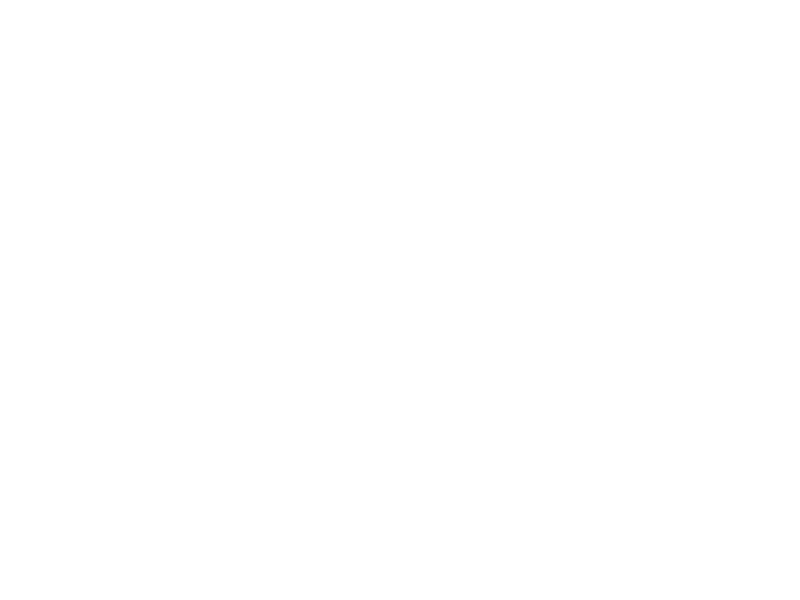

NameError: name 'inputs' is not defined

In [301]:
f,ax = plt.subplots(1,1,figsize = (8,6), sharex = True)


t_dur = inputs[0]['trial_duration']

ct = 'pr_noci'
state_mon = states[ct]
y_bias = 0
x_bias = 0
k=0
for trial in range(0,50,5):
    t_start = trial*t_dur
    t_end = t_start+t_dur
    t_ind = (state_mon.t>=t_start) & (state_mon.t<t_end)
    ax.plot((state_mon.t[t_ind]-t_start)/br.ms+x_bias, state_mon.v[k,t_ind]/br.mV+y_bias,
               color = cmap[0],alpha = 0.7);
    y_bias += 60
    x_bias += 1
plt.tight_layout()

<IPython.core.display.Javascript object>


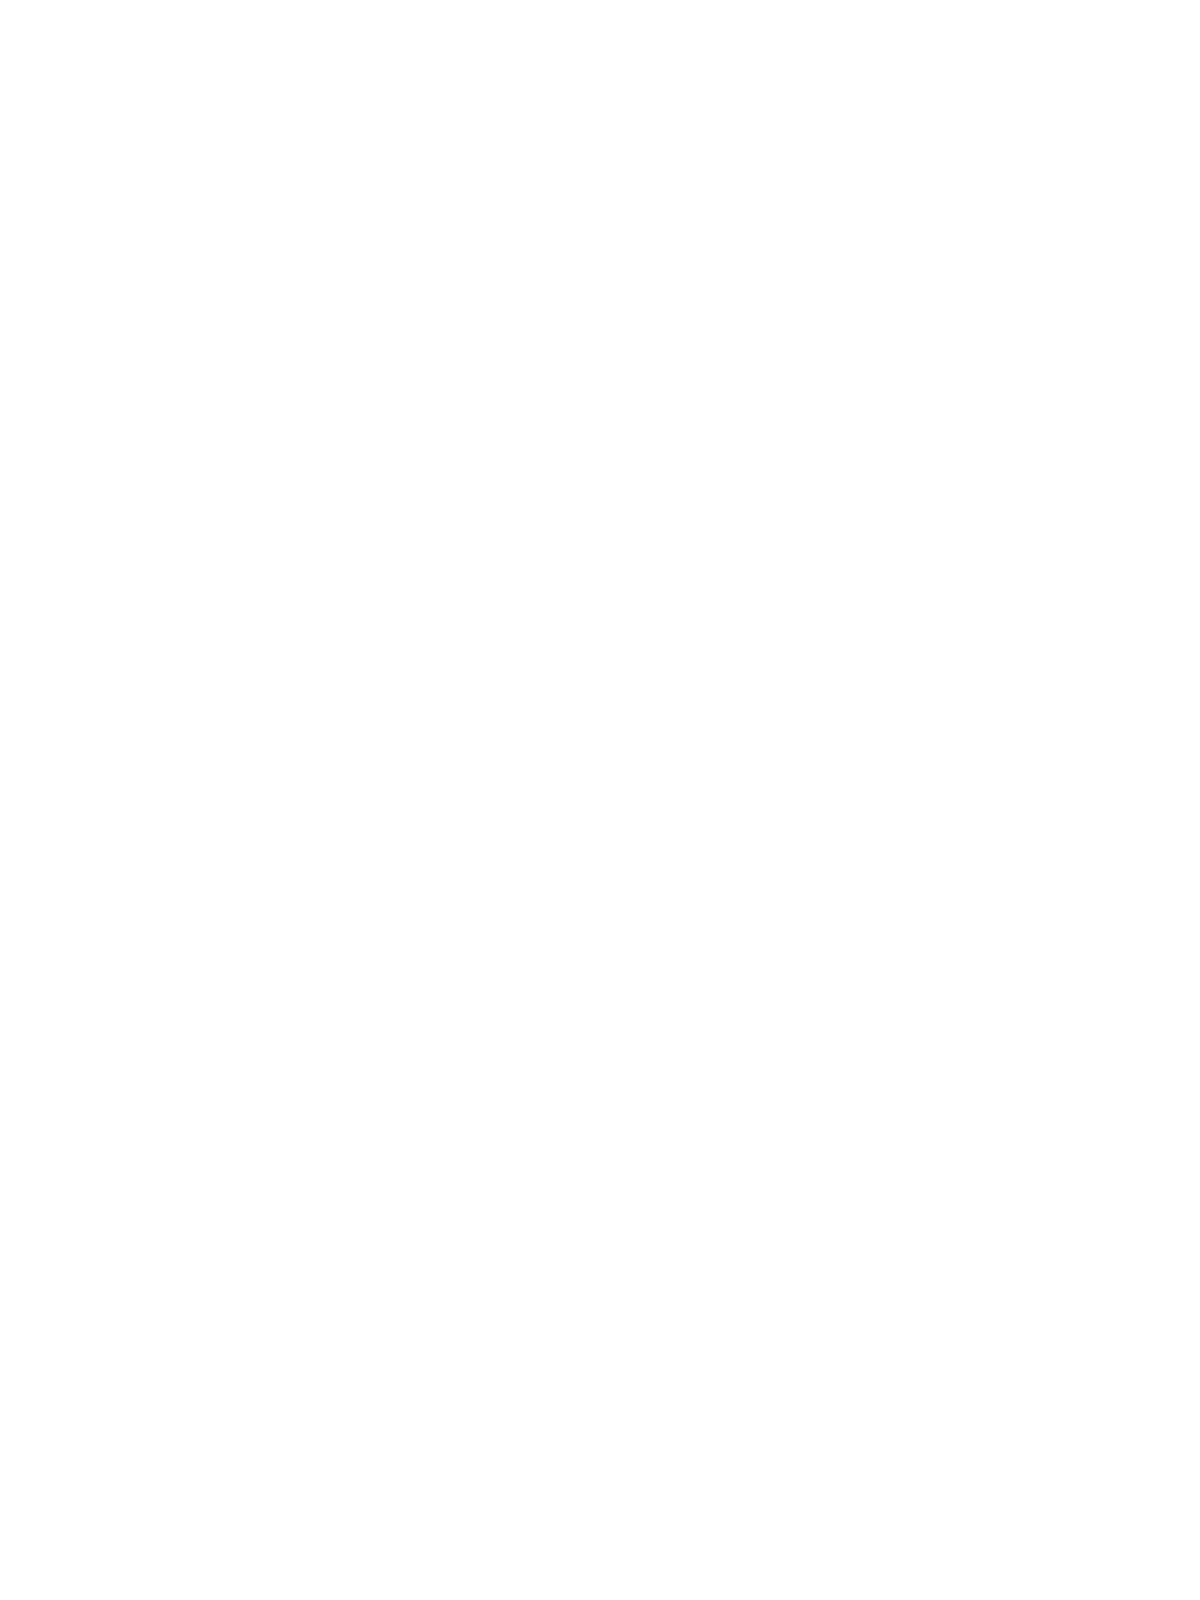

IndexError: index 0 is out of bounds for axis 0 with size 0

In [19]:
state_mon = states['pr_noci']
sns.set_style('darkgrid')
f,ax = plt.subplots(4,1,figsize = (6,8), sharex = True)
ax = ax.flatten()
trial = 30
t_dur = inputs[0]['trial_duration']
t_start = trial*t_dur
t_end = t_start+t_dur
t_ind = (state_mon.t>=t_start) & (state_mon.t<t_end)

labels = ['Nociceptive projection neuron','Excitatory interneuron','Inhibitory interneuron']
for j,(ct,state_mon) in enumerate(states.items()):
    y_bias = 0
    x_bias = 0
    for k in range(1):
        tbase = (state_mon.t[t_ind]-t_start)/br.ms
        trace = state_mon.v[k,t_ind]/br.mV
        ax[j].plot(tbase + x_bias, trace + y_bias,
                   color = cmap[j],alpha = 1);
        y_bias += 20
        x_bias += 1
        ax[j].set_title(labels[j])
        ax[j].set_ylabel('mV')
        
at='pep2'
this_times = ag_inputs_full_trial[at]['spike_times']
this_ind = (this_times>=t_start) & (this_times<t_end)
ax[3].plot((this_times[this_ind]-t_start)/br.ms,
        ag_inputs_full_trial[at]['indices'][this_ind],'.',color='k',alpha = 1)
ax[3].set_title('Nociceptor spiking')
ax[3].set_ylabel('Neuron #')
ax[3].set_xlabel('Time (ms)')
plt.xlim((0,t_dur/br.ms))
plt.tight_layout()
# f.savefig('/Users/nakaa1/data/DH_model_outputs/simple_circuit/heat_ctrl.png',dpi = 300)

In [ ]:
sns.set_style('darkgrid')
f,ax = plt.subplots(4,1,figsize = (6,8), sharex = True)
ax = ax.flatten()
trial =80
t_dur = inputs[0]['trial_duration']
t_start = trial*t_dur
t_end = t_start+t_dur
t_ind = (state_mon.t>=t_start) & (state_mon.t<t_end)

labels = ['Nociceptive projection neuron','Excitatory interneuron','Inhibitory interneuron']
for j,(ct,state_mon) in enumerate(states.items()):
    y_bias = 0
    x_bias = 0
    for k in range(1):
        tbase = (state_mon.t[t_ind]-t_start)/br.ms
        trace = state_mon.v[k,t_ind]/br.mV
        ax[j].plot(tbase + x_bias, trace + y_bias,
                   color = cmap[j],alpha = 1);
        y_bias += 20
        x_bias += 1
        ax[j].set_title(labels[j])
        ax[j].set_ylabel('mV')
        
# ax[3].plot(ag_inputs_full_trial['pep2']['spike_times']/br.ms,
#         ag_inputs_full_trial['pep2']['indices']+y_bias,'.',color='k',alpha = 0.1)
this_times = ag_inputs_full_trial['AB_ltmr']['spike_times']
this_ind = (this_times>=t_start) & (this_times<t_end)
ax[3].plot((this_times[this_ind]-t_start)/br.ms,
        ag_inputs_full_trial['AB_ltmr']['indices'][this_ind],'.',color='y',alpha = 1)
ax[3].set_title('Low-threshold mechanoreceptor spiking')
ax[3].set_ylabel('Neuron #')
ax[3].set_xlabel('Time (ms)')
plt.xlim((0,t_dur/br.ms))
plt.tight_layout()
f.savefig('/Users/nakaa1/data/DH_model_outputs/simple_circuit/mech_ctrl.png',dpi = 300)

['i_WDR0',
 'i_WDR1',
 'i_WDR2',
 'i_WDR3',
 'i_WDR4',
 'i_WDR5',
 'i_WDR6',
 'i_WDR7',
 'i_WDR8',
 'i_WDR9']

In [81]:

for conn_name in sim_objects['synapses']:
    print(conn_name)
pre,post = conn_name.split('_to_')
pre

e_nts_to_pr_noci
e_nts_to_e_nts
e_nts_to_i_WDR
i_WDR_to_pr_noci
i_WDR_to_e_nts
i_WDR_to_i_WDR
pep2_to_pr_noci
pep2_to_i_WDR
AB_ltmr_to_e_nts
AB_ltmr_to_i_WDR


'AB_ltmr'

In [ ]:
sim_objects['synapses']['e_nts_to_pr_noci'].w.shape

In [89]:
?nx.draw_networkx

In [98]:
?nx.spectral_layout

<IPython.core.display.Javascript object>


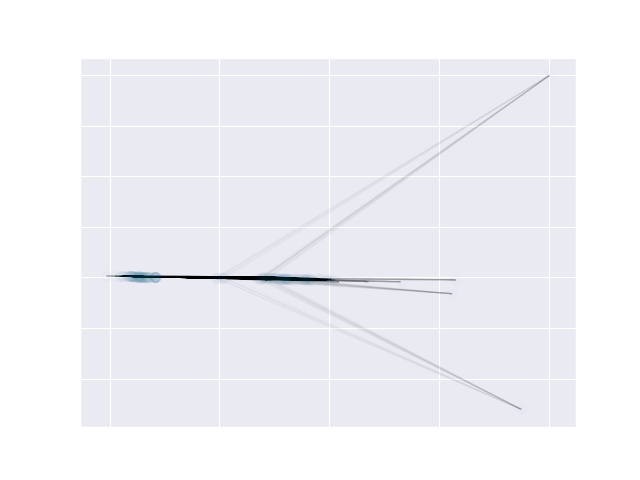

In [83]:
?G.add_edge

<IPython.core.display.Javascript object>


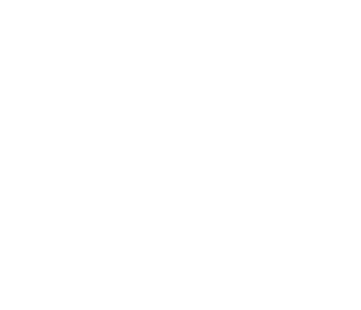

In [63]:
import networkx as nx
G = nx.DiGraph()
G.add_edges_from(
    [('E','I'),('E','P'),('I','P'),('E','E')],weight = 1)

val_map = {'P': cmap[0],
           'E': cmap[1],
           'I': cmap[2],
           }

values = [val_map.get(node, 0.25) for node in G.nodes()]
edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
red_edges = [('C','D'),('D','A')]
edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]

pos=nx.spring_layout(G)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
options = {
    'node_color': values,
    'node_size': 1500,
    'edge_color': edge_colors,
    'arrowstyle': '-|>',
    'arrowsize': 12,
    'arrows':True}
nx.draw_networkx_labels(G, pos)
nx.draw(G,pos, **options)

# pylab.show()
# nx.draw_networkx(G[, pos, arrows, with_labels])

# }
# nx.draw_networkx(G, arrows=True, **options)

# nx.draw(G, cmap = plt.get_cmap('jet'), node_color = values)
plt.show()

In [ ]:
#output = tensor: rates x psth x num_trials
num_trials = 600
block_length = 50
conditions = 4
num_repeats = 1
trial_durations = [duration] * num_trials
inputs = dh.initialize_inputs(ags,ngs,num_trials,trial_durations = trial_durations)
psth_kernel,_ = dh.gaussian_psth(duration, sim_dt, mu = 12.5 * br.ms, sigma = 3 * br.ms)

rates_of_active_pep2 = np.ones((num_trials)) * 10.
rates_of_active_AB_ltmr = np.ones((num_trials)) * 10.


frac_active_pep2 = np.concatenate([np.logspace(-3,0,block_length),
                                   np.zeros(block_length)] * 2 * num_repeats)
# frac_active_pep2 = np.concatenate([np.linspace(0.001,1,block_length),
#                                    np.zeros(block_length)] * 2 * num_repeats)
heat = ([True]*block_length +[False] * block_length) * 2 * num_repeats

frac_active_AB_ltmr = np.concatenate([np.zeros(block_length),
                                      np.logspace(-3,0,block_length)] * 2 * num_repeats )
# frac_active_AB_ltmr = np.concatenate([np.zeros(block_length),
#                                       np.linspace(0.001,1,block_length)] * 2 * num_repeats )
mech = ([False]*block_length +[True] * block_length) * 2 * num_repeats

# frac_active_pep2 = np.random.rand(num_trials)
# frac_active_AB_ltmr = np.random.rand(num_trials)

# frac_active_pep2 = np.concatenate([np.logspace(-3,0,block_length),
#                                    np.zeros(block_length),
#                                    np.random.rand(block_length*2)*0.5] * num_repeats )
# heat = ([True]*block_length +[False] * block_length +[False] * block_length*2)  * num_repeats
# frac_active_AB_ltmr = frac_active = np.concatenate([np.zeros(block_length),
#                                                     np.logspace(-3,0,block_length),
#                                                     np.random.rand(block_length*2)*0.5] * num_repeats)
# mech = ([False] * block_length + [True] * block_length + [False] * block_length*2) * num_repeats

at = 'pep2'
for trial,frac in enumerate(frac_active_pep2):
    _, active_binary = dh.make_active_inds_binary(frac, ags[at].N)
    rate_vec = np.ones((ags[at].N))* rates_of_active_pep2[trial] * active_binary
    spike_times,indices = dh.generate_population_spikes(psth_kernel,rate_vec,sim_dt)
    inputs[trial][at]['spike_times'] = spike_times
    inputs[trial][at]['indices'] = indices


at = 'AB_ltmr'
for trial,frac in enumerate(frac_active_AB_ltmr):
    _, active_binary = dh.make_active_inds_binary(frac, ags[at].N)
    rate_vec = np.ones((ags[at].N))* rates_of_active_AB_ltmr[trial] * active_binary
    spike_times,indices = dh.generate_population_spikes(psth_kernel,rate_vec,sim_dt)
    inputs[trial][at]['spike_times'] = spike_times
    inputs[trial][at]['indices'] = indices
    
df = pd.DataFrame({'frac_active_pep2':frac_active_pep2,
                   'frac_active_AB_ltmr':frac_active_AB_ltmr})
df['heat'] = heat
df['mech'] = mech


# nt = 'i_WDR'
# silenced_i_WDR = np.concatenate([np.zeros(block_length*2),np.ones(block_length*2)*-50000]* num_repeats )
# for trial,current in enumerate(silenced_i_WDR):
#     inputs[trial][nt]['I_ex'] += current
    
# df['silenced_i_WDR'] = silenced_i_WDR
# df['silenced'] = df['silenced_i_WDR']<0

In [ ]:
bins = np.arange(0,net.t/br.ms,10)
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(3,1,figsize = (12,8), sharex = True)
ax = ax.flatten()
y_bias = 0
for j,(ct,spike_mon) in enumerate(spike_mons.items()):
    sns.distplot(spike_mon.t/br.ms, ax = ax[j], bins = bins, color = cmap[j])
plt.tight_layout()

# ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
# ax.set_xlim((0,net.t/br.ms))

In [ ]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for j,(ct,spike_mon) in enumerate(spike_mons.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[j],alpha = 1);
    y_bias += ngs[ct].N
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
ax.set_xlim((0,net.t/ms))

In [ ]:
update_funcs = {}
# ng_vpl= [('pr_WDR','E_l'),('e_WDR','E_l')]
# update_funcs.update(gen_intrinsics_update_funcs(ngs,ng_vpl))
update_funcs.update(gen_s_w_update_funcs(s))

In [ ]:
global tracker
tracker ={}
tracker['beta'] = []
tracker['observed_spikes'] =[]
tracker['cost']=[]
opts = {}
opts['tracker'] = tracker
opts['track'] = True
opts['verbose'] = True

bounds = [(0,5)] * 6 + [(0,1)] * 3

res = op.differential_evolution(func = dh.fit_network,bounds = bounds,
    args = [update_funcs, sim_objects, inputs, target_outputs, dh.mean_spike_count_cost_func, opts],polish = False,
    maxiter = 30)

In [ ]:
def calc_pop_rates_per_trial(spks,num_trials,duration):
    ng_counts = {}
    ng_counts_avg ={}
    for nt,spikemon in spks.items():
        trial_start = 0 * ms
        spike_trains = spikemon.spike_trains()
        ng_counts[nt] = np.zeros((len(spike_trains.keys()),num_trials))
        ng_counts_avg[nt] = np.zeros((num_trials))
        for trial in range(num_trials):
            trial_end = trial_start + duration
            for n,times in spike_trains.items():
                this_count = sum((times>=trial_start) & (times<trial_end))
                ng_counts[nt][n,trial]= this_count
            ng_counts_avg[nt][trial] = ng_counts[nt][:,trial].mean()
            trial_start += duration
    return ng_counts,ng_counts_avg

def cost_func(target_ng_rates, measured_ng_rates, nts = ['pr_noci','pr_WDR']):
    cost = 0.
    for nt in nts:
        cost += sum((target_ng_rates[nt] - measured_ng_rates[nt])**2) **0.5
    return cost

In [ ]:
st = spike_mons['i_WDR'].spike_trains()[0]
trial_start = 20*ms
trial_end = 50 * ms
st[(st>=trial_start) & (st<trial_end)]

In [ ]:
trialwise_spikes = get_trialwise_spikes(inputs, sim_objects)
trialwise_spikes[0]['i_WDR']

In [ ]:
target_outputs

In [ ]:
inputs[0]['pr_noci']

In [ ]:
def adjust_params_and_rerun(net, ngs, ags, s, beta):
    net.restore()
    
    for name, w_mu in beta.items():
        for syn in s:
            if syn.name == name:
                syn.w = (w_mu + 0.000001 * randn(syn.w.shape[0]))* nS
                syn.w['w < 0 * nS'] = 0 * nS
                
    #resetting
    for trial in range(num_trials):
        for nt,ng in ngs.items():
            ng.reset_variables()
        for at,ag in ags.items():
            this_rate = ag_rates[at][trial]
            psth, time_bins = uniform_psth()
            rates = np.ones((ag.N)) * this_rate
            spikes,ind = generate_population_spikes(psth,rates)
            ag.set_spikes(indices = ind, times = spikes + net.t)
        net.run(duration)


    ng_counts,ng_counts_avg = calc_pop_rates_per_trial(spks,num_trials,duration)
    measured_ng_rates = {}
    for nt,counts_avg in ng_counts_avg.items():
        measured_ng_rates[nt] = counts_avg / duration*second    
    return measured_ng_rates

def run_network_change_syn(x, net, ngs, ags, s, free_s_params, target_ng_rates):
    beta = {}
    for free_s_param,this_x in zip(free_s_params,x):
        beta[free_s_param] = this_x
    measured_ng_rates = adjust_params_and_rerun(net, ngs, ags, s, beta)
    cost = cost_func(target_ng_rates, measured_ng_rates, nts = ['pr_noci','pr_WDR'])
    
#     beta_.append(x)
#     rates_.append(rates)
#     cost_.append(cost)
    print(x, cost)

    return cost

In [ ]:
bounds = [(0.5,8),(0.5,8),(0.5,8),(0.5,8),(0.5,8),(0.5,8)]
bounds = [(0.5,8)] * len(free_s_params)
res = op.differential_evolution(func = run_network_change_syn,bounds = bounds,
                                args = [net, ngs,ags,s,free_s_params,target_ng_rates],polish = False,
                                maxiter = 1)

In [ ]:
ng_counts,ng_counts_avg = calc_pop_rates_per_trial(spks,num_trials,duration)
measured_ng_rates = {}
for nt,counts_avg in ng_counts_avg.items():
    measured_ng_rates[nt] = counts_avg / duration*second    

In [ ]:
cost_func(target_ng_rates,measured_ng_rates)

In [ ]:
ng_counts_avg['pr_noci']

In [ ]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spks.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 1);
    y_bias += ngs[ct].N
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
ax.set_xlim((0,net.t/ms))

In [ ]:

f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
for z,(nt,counts) in enumerate(ng_counts.items()):
    ax.plot(np.arange(num_trials),counts.mean(axis=0),'-o',color = cmap[z])
        

In [ ]:
counts.mean(axis = 0)

In [ ]:
net.t/duration

In [ ]:
outrate = poprates['pr_noci'].smooth_rate(width = 100 *ms)

In [ ]:
spks['e_grp'].t

In [ ]:
#restoring
hold_spikes = {}
for nt in ngs.keys():
    hold_spikes[nt] = {'ind':[],'spikes':[]}
for trial in range(num_trials):
    net.restore()
    for at,ag in ags.items():
        this_rate = ag_rates[at][trial]
        psth, time_bins = uniform_psth()
        rates = np.ones((ag.N)) * this_rate
        spikes,ind = generate_population_spikes(psth,rates)
        ag.set_spikes(indices = ind, times = spikes)
    net.run(duration, profile = True, report = 'text')
    
    for nt in ngs.keys():
        hold_spikes[nt]['ind'].append(ind.copy())
        hold_spikes[nt]['spikes'].append(spikes.copy())

In [ ]:
af_cts = ['AB_ltmr']
af_ngs = {}
af_params = {}
ct ='AB_ltmr'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.add_stim('electrical', start_time = 10 * ms)
constructor.params['outputs']['e_nts']['p'] = 1
constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
constructor.params['outputs']['e_tac2']['p'] = 1
constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
constructor.params['outputs']['i_pv']['p'] = 1
constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()
af_params['AB_ltmr']

In [ ]:
af_cts = ['AB_ltmr']
af_ngs = {}
af_params = {}
for ct in af_cts:
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.add_stim('electrical', start_time = 10 * ms)
    constructor.params['outputs']['e_nts']['p'] = 1
    constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
    constructor.params['outputs']['e_tac2']['p'] = 1
    constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['e_tac2']['w_sigma'] = 0.01 * nS
    constructor.params['outputs']['i_pv']['p'] = 1
    constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['i_pv']['w_sigma'] = 0.01 * nS
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

default_e = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'e'}
default_i = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'i'}

cts = ['e_nts','e_tac2','i_pv']
ngs = {}
params = {}
i_ex = {}

ct = 'e_nts'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2'] = default_e.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts'] = default_e.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_e.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS

ct = 'e_tac2'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2']= default_e.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts']= default_e.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_e.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS

ct = 'i_pv'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2']= default_i.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts']= default_i.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_i.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS


spikes = {}
for cell_type in params:
    spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)    

synapses=[]
for pre, outputs in params.items():
    for post in outputs['outputs']:
        if post in params.keys():
            synapses.append(connect_neuron_groups(ngs[pre], ngs[post],**outputs['outputs'][post]))

for pre, outputs in af_params.items():
    for post in outputs['outputs']:
        if post in params.keys():
                synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

for ct in cts:
    initialize_I_ex(ngs[ct], i_ex[ct])

net = Network(ngs,spikes,synapses,af_ngs)
net.store()


In [ ]:
beta = np.array([1,1,1,1,1,1,5,0.3,0.3])
change_S_and_rerun(net, synapses, beta)

In [ ]:
global beta_
global rates_
global cost_
beta_ = []
rates_ = []
cost_ = []

In [ ]:
def change_S_and_rerun(net, synapses, beta):
    net.restore()
    for n,this_w in enumerate(beta):
        synapses[n].w = (this_w + 0.001 * randn(synapses[n].w.shape[0]))* nS
        synapses[n].w['w < 0 * nS'] = 0 * nS
    net.run(duration)

    rates = []
    for ct in cts:
        rates.append(spikes[ct].t.shape[0]/params[ct]['N'])
    rates = np.array(rates)
    return rates, spikes

def run_network_change_syn(x, net, synapses, target_rates):

    rates, spikes = change_S_and_rerun(net, synapses, x)
    cost = np.sum((rates-target_rates) **2)
    
    beta_.append(x)
    rates_.append(rates)
    cost_.append(cost)
    print(x, rates, cost)
    return cost

In [ ]:


def run_3_pop_w_ext_input(beta):
    af_cts = ['AB_ltmr']
    af_ngs = {}
    af_params = {}
    for ct in af_cts:
        constructor = afferent_group()
        constructor.select_cell_type(ct)
        constructor.add_stim('electrical', start_time = 10 * ms)
        constructor.params['outputs']['e_nts']['p'] = 1
        constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
        constructor.params['outputs']['e_tac2']['p'] = 1
        constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['e_tac2']['w_sigma'] = 0.01 * nS
        constructor.params['outputs']['i_pv']['p'] = 1
        constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['i_pv']['w_sigma'] = 0.01 * nS
        af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

    default_e = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'e'}
    default_i = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'i'}

    cts = ['e_nts','e_tac2','i_pv']
    ngs = {}
    params = {}
    i_ex = {}

    ct = 'e_nts'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2'] = default_e.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[0] * nS
    params[ct]['outputs']['e_nts'] = default_e.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[1] * nS
    params[ct]['outputs']['i_pv'] = default_e.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[2] * nS

    ct = 'e_tac2'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2']= default_e.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[3] * nS
    params[ct]['outputs']['e_nts']= default_e.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[4] * nS
    params[ct]['outputs']['i_pv'] = default_e.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[5] * nS

    ct = 'i_pv'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2']= default_i.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[6] * nS
    params[ct]['outputs']['e_nts']= default_i.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[7] * nS
    params[ct]['outputs']['i_pv'] = default_i.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[8] * nS

    
    spikes = {}
    for cell_type in params:
        spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)    

    synapses=[]
    for pre, outputs in params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                synapses.append(connect_neuron_groups(ngs[pre], ngs[post],**outputs['outputs'][post]))

    for pre, outputs in af_params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                    synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

    for ct in cts:
        initialize_I_ex(ngs[ct], i_ex[ct])

    net = Network(ngs,spikes,synapses,af_ngs)
    net.run(duration)

    rates = []
    for ct in cts:
        rates.append(spikes[ct].t.shape[0]/params[ct]['N'])
    rates = np.array(rates)
    return rates, spikes

def run_network(beta, target_rates):
    rates, spikes = run_3_pop_w_ext_input(beta)
    cost = np.sum((rates-target_rates) **2)
    print(beta, cost)
    return cost

In [ ]:
target_rates = np.array([15,5,16])
bounds = [(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3)]
res = op.differential_evolution(func = run_network_change_syn,bounds = bounds,
                                args = [net, synapses, target_rates],polish = False,
                                maxiter = 20)

In [ ]:
f,ax = plt.subplots(3,3,figsize = (12,12))
ax = ax.flatten()
for n in range(9):
    sns.kdeplot(df[n],df['cost'],ax = ax[n])
    sns.scatterplot(df[n],df['cost'],alpha = 0.4,ax = ax[n])

In [ ]:
df = pd.DataFrame(np.stack(beta_))
df['cost'] = np.array(cost_)


In [ ]:
beta_true = np.array([1.19, 0.68, 1.4, 1.5, 0.73, 2.96,
 0.38, 1.60, 2.18])
rates, spikes = run_3_pop_w_ext_input(beta_true)

In [ ]:

# net.add()
net.store()

In [ ]:
net.restore()

In [ ]:
bins = np.arange(0,duration/ms,1)
cmap = sns.color_palette("hls", 15)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[i], bins = bins, color = cmap[i])
    ax[i].set_title(ct)
plt.tight_layout()

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 0.5);
    y_bias += params[ct]['N']
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))

In [ ]:

ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = 7 * nS
constructor.add_spikes(indices = array([0]), spikes = array([5])* ms)
pre, pre_params = constructor.generate_afferent_group()


ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['tau_e'] = 1 * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()


states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
    
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)  

net.store()

In [ ]:
net.run(duration, report = 'text',profile = True)

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
plt.xlim((5,20))

In [ ]:
x = [7.1351391, 14.7825336, 2.29645621, 2.4902152]
ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
pre, pre_params = constructor.generate_afferent_group()
ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
constructor.params['intrinsics']['tau_e'] = x[3] * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()

states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)
net.run(duration)
fit_v = states.v_[0].copy()

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
# plt.xlim((5,20))

In [ ]:
from scipy import optimize as op
def run_network(x, train_v):
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    pre, pre_params = constructor.generate_afferent_group()
    ct = 'i_gal'
    ngs = {}
    params = {}
    i_ex = {}
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
    constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
    constructor.params['intrinsics']['tau_e'] = x[3] * ms
    constructor.params['intrinsics']['E_l'] = -70 * mV
    post, post_params, i_ex = constructor.generate_neuron_group()

    states= StateMonitor(post, ['v','g_e','g_i'], record=True)
    spikes= SpikeMonitor(pre, record=True)
    syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

    initialize_I_ex(post, i_ex)

    net = Network(post,states,spikes,syn,pre)
    net.run(duration)
    fit_v = states.v_[0].copy()
    cost = np.sum((fit_v -train_v) **2)
    print(x, cost)
    return cost

In [ ]:
bounds = [(0.1,30),(13,20),(0.5,5),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

In [ ]:
train_v = states.v_[0]

In [ ]:
from scipy import optimize as op
def run_network(x, train_v):
    
  
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.params['outputs']['i_gal']['w_sigma'] = 0.0001 * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

    cts = ['i_gal']
    ngs = {}
    params = {}
    i_ex = {}
    for ct in cts:
        constructor = neuron_group_constructor()
        constructor.select_cell_type(ct)
        constructor.params['N'] = 1
        constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
        constructor.params['intrinsics']['tau_e'] = x[2] * ms
        ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()

    states={}
    spikes = {}
    for cell_type in params:
        states[cell_type]= StateMonitor(ngs[cell_type], ['v','g_e','g_i'], record=True)
        spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)

    synapses=[]

    for pre, outputs in af_params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                    print(pre,post)
                    synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

    for ct in cts:
        initialize_I_ex(ngs[ct], i_ex[ct])

    net = Network(ngs,states,spikes,synapses,af_ngs)
    net.run(duration)
    fit_v = states['i_gal'].v_[0].copy()
    return np.sum((fit_v -train_v) **2)


In [ ]:
bounds = [(0,50),(0.1,10),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

In [ ]:
res

In [ ]:
cmap = sns.color_palette("hls", 15)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
bins = np.arange(0,duration/ms,1)
for n,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[n], bins = bins, color = cmap[n])
    ax[n].set_title(ct)
plt.tight_layout()


In [ ]:
spikes.items()

In [ ]:
f,ax = plt.subplots(len(spikes),1,figsize = (8,20), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax[i].plot(spike_mon.t/ms, spike_mon.i,'.', color = cmap[i],alpha = 0.1);
    ax[i].set_title(ct)
plt.tight_layout()

In [ ]:
state_mon.v_.shape

In [ ]:
def make_spikes_pretty(spikemon,statemon,spike_height = 0.040):
    inds = spikemon.i
    time_inds = spikemon.t/sim_dt
    time_inds = time_inds.astype(int)
    for i,t in zip(inds,time_inds):
        statemon.v_[i,t] = spike_height

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,16))
for i,(ct,state_mon) in enumerate(states.items()):
    make_spikes_pretty(spikes[ct],state_mon)
    ax[i].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,8))
for i,(ct,state_mon) in enumerate(states.items()):
    ax[i].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);
    ax[i].set_title(ct)

# afferent inputs
AB_psth,time_bins = gaussian_psth(mu = 10 * ms, sigma = 1 * ms)
AD_psth,time_bins = gaussian_psth(mu = 20 * ms, sigma = 2 * ms)
C_psth,time_bins = gaussian_psth(mu = 120 * ms, sigma = 20 * ms)

C_spikes, C_ind = generate_population_spikes(C_psth,np.ones(50)*2)
AB_spikes, AB_ind = generate_population_spikes(AB_psth,np.ones(10)*5)
AD_spikes, AD_ind = generate_population_spikes(AD_psth,np.ones(10)*5)
f, ax = plt.subplots(2,1,figsize = (8,8), sharex = True)
ax[0].plot(AB_spikes, AB_ind,'.k')
ax[0].plot(AD_spikes, AD_ind+10,'.b')
ax[0].plot(C_spikes, C_ind+20,'.r')
ax[1].plot(time_bins, AB_psth,'k')
ax[1].plot(time_bins, AD_psth,'b')
ax[1].plot(time_bins, C_psth,'r')